# Similarity Analysis among New York, Toronto and Hong Kong

## 1. Business Background

New York, Toronto and Hong Kong and famous cities in the world. It is worthy to have a similarity analysis among these cities to understand the different cultures of different nationalities. According to previous study and based on that, we would like to use Foursqaure data to provide the most popular type of venues in different neighborhoods for analysis. Where New York and Toronto are in North America but different countries, and Hong Kong is in Asia, we expect Toronto is more similar to New York than Hong Kong.

*(referring to Couresra Project Week 4 Part 1)*

## 2. Analytic Approach

Given that we have the geolocation data of New York and Toronto, we also prepare the data for Hong Kong referring to their post offices' addresses. This data is provided by https://geodata.gov.hk/.

Make use of the geolocations, it represents the neighborhoods of an area and we can use Foursqaure API to get the list of venues surrounding. In order to compare the cities, we will sum up the counts of common places of the city to prepare the top 10 common places to compare.

Down to the neighborhoods, we will also apply K-MEAN clustering to label the different neighborhoods to see if the classes are evenly distribute or not.

*(referring to Couresra Project Week 4 Part 2)*

## 3. Data

### 3.1 Data Requirement

1. List of Neighborhoods and Boroughs of New York with geolocations
2. List of Neighborhoods and Boroughs of Toronto with geolocations
3. List of Neighborhoods and Boroughs of Hong Kong with geolocations
4. List of places surround Neighborhoods in New York City by Foursquare
5. List of places surround Neighborhoods in Toronto City by Foursquare
6. List of places surround Neighborhoods in Hong Kong City by Foursquare

### 3.2 Data Collection and Preprocess

In [238]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt;

print('Libraries imported.')

Libraries imported.


#### 3.2.1 List of Neighborhoods and Boroughs of New York with geolocations

In [55]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [56]:
neighborhoods_data = newyork_data['features']

In [57]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_nyc_neighborhoods = pd.DataFrame(columns=column_names)

In [58]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_nyc_neighborhoods = df_nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [59]:
df_nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [60]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_nyc_neighborhoods['Borough'].unique()),
        df_nyc_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### 3.2.2 List of Neighborhoods and Boroughs of Toronto with geolocations

In [61]:
df_canada_postal_wiki = pd.read_csv('CANADA_POSTAL_WIKI.csv')
##rename column name as required
df_canada_postal_wiki.columns=['PostalCode','Borough','Neighborhood']

In [62]:
df_canada_neighborhood=df_canada_postal_wiki[df_canada_postal_wiki['Borough']!='Not assigned']

In [63]:
##update Neighbourhood as Borough where Neighbourhood is 'Not assigned'
df_canada_neighborhood['Neighborhood']=np.where(df_canada_neighborhood['Neighborhood']=='Not assigned',df_canada_neighborhood['Borough'],df_canada_neighborhood['Neighborhood'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
df_coordindates = pd.read_csv('Geospatial_Coordinates.csv')

In [65]:
df_coordindates.columns=['PostalCode','Latitude','Longitude']

In [66]:
df_canada_neigh_coord=df_canada_neighborhood.merge(df_coordindates, on='PostalCode', how='left')
df_toronto_neighborhoods=df_canada_neigh_coord[df_canada_neigh_coord['Borough'].str.contains('Toronto')].reset_index(drop=True)
df_toronto_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


In [67]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_canada_neigh_coord['Borough'].unique()),
        df_canada_neigh_coord.shape[0]
    )
)

The dataframe has 11 boroughs and 210 neighborhoods.


#### 3.2.3 List of Neighborhoods and Boroughs of Hong Kong with geolocations

In [68]:
df_hk_postoffice_full = pd.read_csv('HKGS_Dataset_Post-Offices_2020-01-06-1059-54_fullset.csv')

In [69]:
df_hk_postoffice_full.dtypes

GMID                  object
Dataset               object
Facility Name         object
Address               object
數據集                   object
設施名稱                  object
地址                    object
District              object
地區                    object
Opening Hours         object
開放時間                  object
Telephone             object
聯絡電話                  object
Fax Number            object
傳真號碼                  object
Email Address         object
電郵地址                  object
Website               object
網頁                    object
Scope of Services     object
服務範圍                  object
Remarks               object
備註                    object
Northing             float64
Easting              float64
Latitude             float64
Longitude            float64
Last Update           object
dtype: object

In [70]:
df_hk_postoffice = df_hk_postoffice_full[['Facility Name','District','Latitude','Longitude']]
df_hk_postoffice.head()

,Facility Name,District,Latitude,Longitude
0,Stanley Post Office,SOUTHERN,22.21818,114.21326
1,So Uk Post Office,SHAM SHUI PO,22.34111,114.15655
2,Kam Tai Post Office,SHA TIN,22.40887,114.22189
3,Kwong Yuen Post Office,SHA TIN,22.38067,114.21615
4,Cheung Sha Wan Post Office,SHAM SHUI PO,22.33880,114.15225


In [71]:
df_hk_postoffice['Facility Name']=df_hk_postoffice['Facility Name'].str.replace(" Post Office","")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
# instantiate the dataframe
df_hk_neighborhoods = df_hk_postoffice
df_hk_neighborhoods.columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'] 
df_hk_neighborhoods.head()

,Neighborhood,Borough,Latitude,Longitude
0,Stanley,SOUTHERN,22.21818,114.21326
1,So Uk,SHAM SHUI PO,22.34111,114.15655
2,Kam Tai,SHA TIN,22.40887,114.22189
3,Kwong Yuen,SHA TIN,22.38067,114.21615
4,Cheung Sha Wan,SHAM SHUI PO,22.33880,114.15225


In [73]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_hk_neighborhoods['Borough'].unique()),
        df_hk_neighborhoods.shape[0]
    )
)

The dataframe has 18 boroughs and 124 neighborhoods.


#### 3.2.4 List of places surround Neighborhoods in New York City by Foursquare

In [74]:
CLIENT_ID = 'M3Y3EFYSMBDVZKMO234YW20Z3V0QZNZYSVPVXJBB2AULYJAH' # your Foursquare ID
CLIENT_SECRET = 'QYPSRYJ4H5CBGX005Z0FED05CABDZBDPNAY5CEWN5RK5C4BS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M3Y3EFYSMBDVZKMO234YW20Z3V0QZNZYSVPVXJBB2AULYJAH
CLIENT_SECRET:QYPSRYJ4H5CBGX005Z0FED05CABDZBDPNAY5CEWN5RK5C4BS


In [75]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [76]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [79]:
df_nyc_neighborhoods.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [78]:
nyc_venues = getNearbyVenues(names=df_nyc_neighborhoods['Neighborhood'],
                                   latitudes=df_nyc_neighborhoods['Latitude'],
                                   longitudes=df_nyc_neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [80]:
print(nyc_venues.shape)
nyc_venues.head()

(10249, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### 3.2.5 List of places surround Neighborhoods in Toronto by Foursquare

In [81]:
df_toronto_neighborhoods.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
69,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675
70,M5X,Downtown Toronto,First Canadian Place,43.648429,-79.382280
71,M5X,Downtown Toronto,Underground city,43.648429,-79.382280
72,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
73,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


In [82]:
toronto_venues = getNearbyVenues(names=df_toronto_neighborhoods['Neighborhood'],
                                   latitudes=df_toronto_neighborhoods['Latitude'],
                                   longitudes=df_toronto_neighborhoods['Longitude']
                                  )

Harbourfront
Queen's Park
Ryerson
Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North
Forest Hill West
High Park
The Junction South
North Toronto West
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Davisville
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city

In [83]:
print(toronto_venues.shape)
toronto_venues.head()

(3237, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


#### 3.2.6 List of places surround Neighborhoods in Hong Kong by Foursquare

In [84]:
df_hk_neighborhoods.tail()

,Neighborhood,Borough,Latitude,Longitude
119,Wong Tai Sin,WONG TAI SIN,22.34117,114.19247
120,Mong Kok,YAU TSIM MONG,22.32206,114.16818
121,Sham Shui Po,SHAM SHUI PO,22.33186,114.16354
122,Lam Tin,KWUN TONG,22.30867,114.23494
123,Yeung Uk Road,TSUEN WAN,22.36623,114.11824


In [85]:
hk_venues = getNearbyVenues(names=df_hk_neighborhoods['Neighborhood'],
                                   latitudes=df_hk_neighborhoods['Latitude'],
                                   longitudes=df_hk_neighborhoods['Longitude']
                                  )

Stanley
So Uk
Kam Tai
Kwong Yuen
Cheung Sha Wan
Hennessy Road
Wyndham Street
Tin Yiu
Ma On Shan
Kowloon Bay
Shek Lei
Wo Che
Tseung Kwan O
Wah Ming
Fu Tai
Tsuen Wan
Kwun Tong
Causeway Bay
General
Butterfly
Lok Fu
Hung Hom Bay
Ngau Tau Kok
Concorde Road
Yau Yat Tsuen
Yau Tong
Wan Tau Tong
Wah Fu
Tsing Yi
Tsuen Wan West
Tsz Wan Shan
Tai Kok Tsui
Tai Hing
Shek Wai Kok
Sha Tau Kok
San Tin
Sun Chui
Sau Mau Ping
Shek Kip Mei
Sheung Tak
Shun Lee
Sha Kok
Repulse Bay
Po Lam
Perkins Road
Pok Fu Lam
Peak
Oi Man
Ngau Chi Wan
Mei Lam
Lei Tung
Lei Muk Shue
Lai Kok
Lai King
Leung King
Lee On
Kwai Chung
Kwai Shing
Kam Tin
Hin Keng
Ho Man Tin
Heng On
Heng Fa Chuen
Granville Road
Fu Shin
Fu Shan
Fairview Park
Choi Ming
Chuk Yuen
Chai Wan
Choi Hung Chuen
Cheung Fat
Cyberport
Ap Lei Chau
Central Mail Centre
Bulk Air Mail Centre
Air Mail Centre
Tsim Sha Tsui
Sha Tin Central
City One Shatin
Fanling
Airport
Yuen Long
Mei Foo Sun Chuen
Aberdeen
Kowloon East
Kennedy Town
Cheung Chau
Hing Man Street
King's Road


In [86]:
print(hk_venues.shape)
hk_venues.head()

(3641, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stanley,22.21818,114.21326,Stanley Promenade (赤柱海濱長廊),22.218494,114.211572,Pedestrian Plaza
1,Stanley,22.21818,114.21326,Smugglers Inn,22.218527,114.211176,Bar
2,Stanley,22.21818,114.21326,Stanley Main Beach (赤柱正灘),22.219551,114.214011,Beach
3,Stanley,22.21818,114.21326,Cali-Mex Bar & Grill,22.218354,114.211106,Mexican Restaurant
4,Stanley,22.21818,114.21326,Stanley Market (赤柱市集),22.218900,114.212555,Market


## 4. Methodology

### 4.1 Analysis on City level

In [211]:
df_nyc_count=nyc_venues['Venue Category'].value_counts().reset_index()
df_toronto_count=toronto_venues['Venue Category'].value_counts().reset_index()
df_hk_count=hk_venues['Venue Category'].value_counts().reset_index()

In [212]:
observe_rank=30
nyc_top=df_nyc_count['index'][0:observe_rank].values
toronto_top=df_toronto_count['index'][0:observe_rank].values
hk_top=df_hk_count['index'][0:observe_rank].values

In [213]:
def make_comparison_matrix(observe_rank):
    nyc_top=df_nyc_count['index'][0:observe_rank].values
    toronto_top=df_toronto_count['index'][0:observe_rank].values
    hk_top=df_hk_count['index'][0:observe_rank].values
    
    nyc_common=["{:.2%}".format(len(set(nyc_top).intersection(nyc_top))/observe_rank),"{:.2%}".format(len(set(nyc_top).intersection(toronto_top))/observe_rank),"{:.2%}".format(len(set(nyc_top).intersection(hk_top))/observe_rank)]
    toronto_common=["{:.2%}".format(len(set(toronto_top).intersection(nyc_top))/observe_rank),"{:.2%}".format(len(set(toronto_top).intersection(toronto_top))/observe_rank),"{:.2%}".format(len(set(toronto_top).intersection(hk_top))/observe_rank)]
    hk_common=["{:.2%}".format(len(set(hk_top).intersection(nyc_top))/observe_rank),"{:.2%}".format(len(set(hk_top).intersection(toronto_top))/observe_rank),"{:.2%}".format(len(set(hk_top).intersection(hk_top))/observe_rank)]
    
    comparison_matrix = pd.DataFrame({'City':['NYC','Toronto','HK'],'NYC':nyc_common,'Toronto':toronto_common,'HK':hk_common})
    print(comparison_matrix)

In [214]:
make_comparison_matrix(10)

      City      NYC  Toronto       HK
0      NYC  100.00%   50.00%   20.00%
1  Toronto   50.00%  100.00%   40.00%
2       HK   20.00%   40.00%  100.00%


In [215]:
make_comparison_matrix(30)

      City      NYC  Toronto       HK
0      NYC  100.00%   60.00%   40.00%
1  Toronto   60.00%  100.00%   43.33%
2       HK   40.00%   43.33%  100.00%


In [216]:
make_comparison_matrix(50)

      City      NYC  Toronto       HK
0      NYC  100.00%   58.00%   52.00%
1  Toronto   58.00%  100.00%   50.00%
2       HK   52.00%   50.00%  100.00%


In [217]:
make_comparison_matrix(100)

      City      NYC  Toronto       HK
0      NYC  100.00%   66.00%   63.00%
1  Toronto   66.00%  100.00%   63.00%
2       HK   63.00%   63.00%  100.00%


### 4.2 Analysis on Neighborhoods level

In [218]:
def category_normalization(city_venues):
    # one hot encoding
    city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = city_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]
    
    return city_onehot

In [219]:
toronto_onehot=category_normalization(toronto_venues)
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Harbourfront,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [220]:
toronto_onehot.shape

(3237, 240)

In [221]:
hk_onehot=category_normalization(hk_venues)
hk_onehot.head()

,Zoo,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Huaiyang Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soba Restaurant,Social Club,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [222]:
hk_onehot.shape

(3641, 272)

In [223]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [224]:
def return_neighborhood_venues_sorted(city_grouped):
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)
    
    return neighborhoods_venues_sorted

In [225]:
def kmeans_clustering(city_grouped, city_neighborhoods):
    # set number of clusters
    kclusters = 5

    city_grouped_clustering = city_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    
    neighborhoods_venues_sorted=return_neighborhood_venues_sorted(city_grouped)
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

    city_merged = city_neighborhoods

    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')
    
    return city_merged

In [321]:
def create_city_map(city_merged, kclusters):
    latitude=city_merged.loc[0,'Latitude']
    longitude=city_merged.loc[0,'Longitude']
    
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#8c564b"]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighborhood'], city_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors[cluster-1],
            fill=True,
            fill_color=colors[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [322]:
def create_piechart(city_merged):
    label_count=city_merged['Cluster Labels'].value_counts().reset_index()

    label_count.columns=['Group','Count']
    label_count=label_count.sort_values('Group').reset_index(drop=True)

    sizes=label_count['Count']
    total = sum(sizes)
    
    colors=["#8c564b","#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
    #colors=["#8c564b","#1f77b4","#ff7f0e","#2ca02c","#d62728"]

    labels = label_count['Group']

    fig1, ax1 = plt.subplots(figsize=(6, 5))
    fig1.subplots_adjust(0.3,0,1,1)
    _, _ = ax1.pie(sizes, startangle=90,explode=(0, 0.15, 0, 0, 0),colors=colors)
    ax1.axis('equal')
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['Group %s: %1.1f%%' % (
            l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        prop={'size': 11},
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure
    )

    return plt

In [323]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightcl

In [324]:
nyc_merged=kmeans_clustering(nyc_grouped,df_nyc_neighborhoods)
nyc_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Pharmacy,Ice Cream Shop,Laundromat,Sandwich Place,Pizza Place,Gas Station,Dessert Shop,Donut Shop,Caribbean Restaurant,Deli / Bodega
1,Bronx,Co-op City,40.874294,-73.829939,1,Fried Chicken Joint,Pizza Place,Bus Station,Fast Food Restaurant,Chinese Restaurant,Grocery Store,Park,Mattress Store,Basketball Court,Bagel Shop
2,Bronx,Eastchester,40.887556,-73.827806,1,Caribbean Restaurant,Bus Station,Diner,Deli / Bodega,Fast Food Restaurant,Automotive Shop,Donut Shop,Bowling Alley,Pizza Place,Seafood Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,2,Bus Station,River,Plaza,Women's Store,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Bronx,Riverdale,40.890834,-73.912585,2,Park,Bank,Food Truck,Bus Station,Gym,Plaza,Baseball Field,Home Service,Farm,Ethiopian Restaurant


In [325]:
nyc_map=create_city_map(nyc_merged,5)
nyc_map

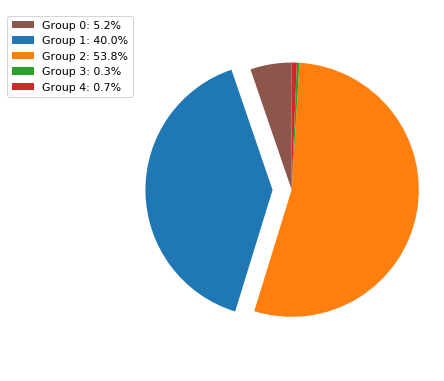

In [326]:
nyc_plt=create_piechart(nyc_merged)
nyc_plt.show()

In [327]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.000000,0.0,0.02,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.02,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,0.000000,0.060000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.0,0.000000,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.00

In [328]:
toronto_merged=kmeans_clustering(toronto_grouped,df_toronto_neighborhoods)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,2,Coffee Shop,Pub,Park,Bakery,Theater,Café,Breakfast Spot,Restaurant,Mexican Restaurant,Ice Cream Shop
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,2,Coffee Shop,Park,Gym,Yoga Studio,Burrito Place,Italian Restaurant,Beer Bar,Japanese Restaurant,Juice Bar,Seafood Restaurant
2,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bakery,Cosmetics Shop,Thai Restaurant,Bubble Tea Shop,Restaurant,Diner
3,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bakery,Cosmetics Shop,Thai Restaurant,Bubble Tea Shop,Restaurant,Diner
4,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Restaurant,Park,Bakery,Diner,Breakfast Spot,Italian Restaurant,Clothing Store,American Restaurant


In [329]:
toronto_map=create_city_map(toronto_merged,5)
toronto_map

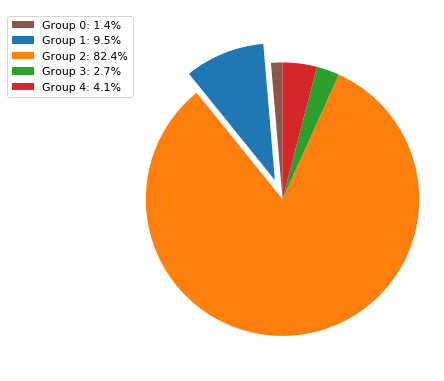

In [330]:
toronto_plt=create_piechart(toronto_merged)
toronto_plt.show()

In [331]:
hk_grouped = hk_onehot.groupby('Neighborhood').mean().reset_index()
hk_grouped.head()

,Neighborhood,Zoo,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Balinese Restaurant,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fujian Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Huaiyang Restaurant,Hunan Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Racecourse,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,Soba Restaurant,Social Club,Soup Place,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant
0,Aberdeen,0.0,0.000000,0.000000,0.000

In [332]:
hk_merged=kmeans_clustering(hk_grouped,df_hk_neighborhoods)
hk_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stanley,SOUTHERN,22.21818,114.21326,0,Café,Bar,Pizza Place,Restaurant,Coffee Shop,American Restaurant,Surf Spot,Italian Restaurant,Gastropub,Mexican Restaurant
1,So Uk,SHAM SHUI PO,22.34111,114.15655,1,Chinese Restaurant,Hong Kong Restaurant,Cha Chaan Teng,Vietnamese Restaurant,Betting Shop,Seafood Restaurant,Fast Food Restaurant,Café,Asian Restaurant,Market
2,Kam Tai,SHA TIN,22.40887,114.22189,1,Café,Park,Hong Kong Restaurant,Bus Station,Shopping Mall,Asian Restaurant,Train Station,Chinese Restaurant,Fast Food Restaurant,Thai Restaurant
3,Kwong Yuen,SHA TIN,22.38067,114.21615,1,Fast Food Restaurant,Bus Station,Bus Stop,Cantonese Restaurant,Convenience Store,Cha Chaan Teng,Malay Restaurant,Chinese Restaurant,Seafood Restaurant,Fish & Chips Shop
4,Cheung Sha Wan,SHAM SHUI PO,22.33880,114.15225,4,Cha Chaan Teng,Shopping Mall,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Sandwich Place,Athletics & Sports,Café,Asian Restaurant,Spanish Restaurant


In [335]:
hk_map=create_city_map(hk_merged,5)
hk_map

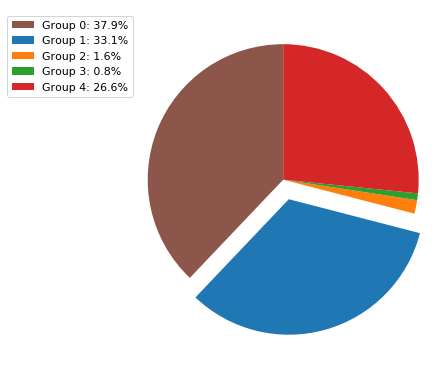

In [334]:
hk_plt=create_piechart(hk_merged)
hk_plt.show()

## 5. Discussion

### 5.1 Results

Let's recap our problem: Is New York City more similar to Toronto rather than Hong Kong?

We adopt the places found by Foursqaure API to observe the features of culture of these 3 cities. First of all(in section 4.1), we study the common top ranked places in these city among top 10, 20, 50 and 100. We assume that the more popular places, the more in demand. In each comparison matrix, we still get the same result that New York City has more common popular places with Toronto compare to Hong Kong. It is suggest that people in the city of New York Cityy and Toronto willing to have the same demandingg trend on the places.

Secondly, we use k-Means to classify the neighborhoods in these 3 cities and observe their distributions. If we use k-Means clustering analysis on the places in different neighborhoods to classify, we have the result as the mapping and pie charts. According to the figures, Totonto's and New York City's neighborhoods are not evenly distributed. They are dominated by the top 2 groups. In other case, the top 3 groups of neighborhoods in Hong Kong dominated theclassifications.

### 5.2 Limitation and Improvement

There are some limitation on this analysis:
1. too few cities for analysis
2. variety of data for analysis
3. data transformation

Due to insufficient data set, we only made analysis on places' categories of these 3 cities. In fact, to make the analysis more fruitful, we should have more cities's information to prepare the analysis.
In order to compare the cities, we should not only focus on the categories of places. We can add the cities' population, GDP, vacation and education data, then we can compare the cities in different angles.
Lastly, we observed that the data retrieved from Foursequare API are too detailed in categories, e.g. Chinese Restaurant, Japanese Restaurant and Pizza Store should be group into restaurant and different from bookstore. Therefore, there should be some cases the same type of category are splitted into small group and their significances are minimized.

### 5.3 Further Study

As mentioned in section 5.2, we can add more dataset for further study. Here is 2 suggestions:
1. Similarity among cities in the same continents
2. Similarity of cities on Economy, Education and Population

## 6. Conclusion

In conclusion, the analysis result shows New York City is more similar to Toronto rather than Hong Kong. For further study, we should includes more dataset of cities' information to have a more fruitful result.